In [1]:
import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

Using TensorFlow backend.


In [24]:
image_batch = np.arange(15, 20)
predictions = np.arange(5)
X = np.concatenate([predictions, image_batch])

In [2]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

4423680/4422102 [==============================] - 3s 1us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [0]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32')

x_train = (x_train - 127.5) / 127.5

img_shape = [28, 28, 1]
z_dim = 100

In [0]:
def generator(img_shape, z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(
                128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(
                64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(
                1, kernel_size=3, strides=2, padding='same'))

    # Tanh activation
    model.add(Activation('tanh'))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

In [0]:
def discrimination(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(Conv2D(32, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Flatten the tensor and apply sigmoid activation function
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [0]:
# Build and compile the Discriminator
discriminator = discrimination(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [0]:
def show_images(generator):  
    # Testing
    # Generate images from noise, using the generator network.
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
      # Noise input.
      z = np.random.uniform(-1., 1., size=[n, 100])
      # Generate image from noise.
      g = generator.predict(z)
      # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
      g = (g + 1.) / 2.
      # Reverse colours for better display
      g = -1 * (g - 1)
      for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

In [0]:
losses = []
accuracies = []
batch_size = 128
iterations = 20000
display_iter = 1000

def train(x_train, iterations, batch_size, display_iter):
    real = np.ones([batch_size, 1])
    fake = np.zeros([batch_size, 1])
    for i in range(iterations):
        img_idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_image = x_train[img_idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
                
        disc_real_loss = discriminator.train_on_batch(real_image, real)
        disc_fake_loss = discriminator.train_on_batch(gen_imgs, fake)
        disc_loss = (disc_real_loss + disc_fake_loss) 
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        gen_loss = combined.train_on_batch(z, real)
        
        if i%display_iter == 0:
            print (i, "D Loss:", disc_loss[0], "D Accuracy:", 100*disc_loss[1], "G Loss:", gen_loss)
            
            losses.append((disc_loss[0], gen_loss))
            accuracies.append(100*disc_loss[1])
            show_images(generator)

D Loss: 0.42147088 D Accuracy: 87.5 G Loss: 0.23547232


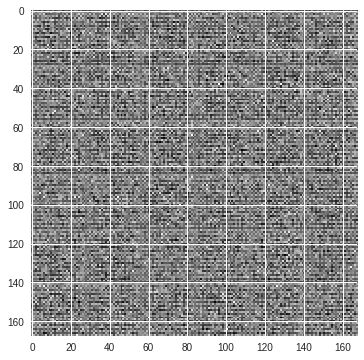

D Loss: 0.026731066 D Accuracy: 100.0 G Loss: 4.973282


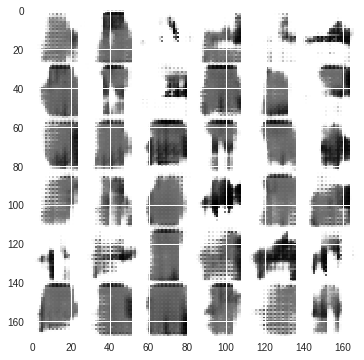

D Loss: 0.05032437 D Accuracy: 98.4375 G Loss: 8.557131


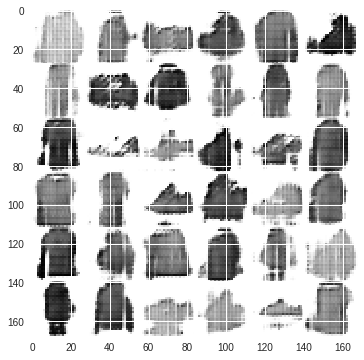

D Loss: 0.07802824 D Accuracy: 98.4375 G Loss: 5.778087


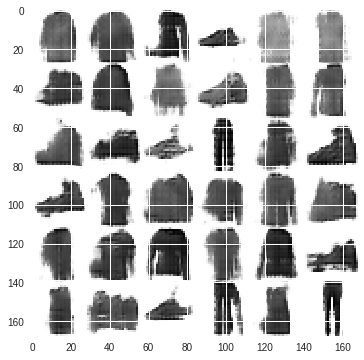

D Loss: 0.0030023237 D Accuracy: 100.0 G Loss: 2.4161935


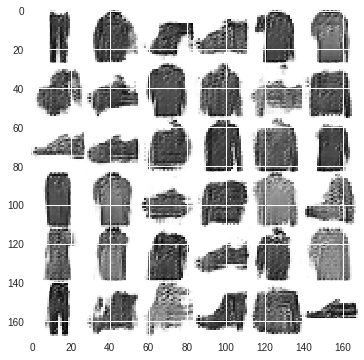

D Loss: 0.09637582 D Accuracy: 96.875 G Loss: 5.8546815


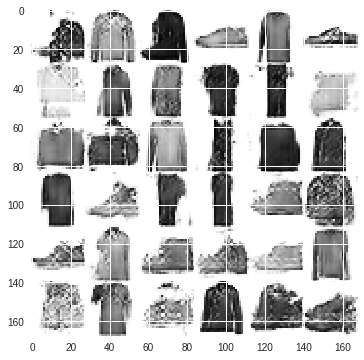

D Loss: 0.15840368 D Accuracy: 93.75 G Loss: 1.8397417


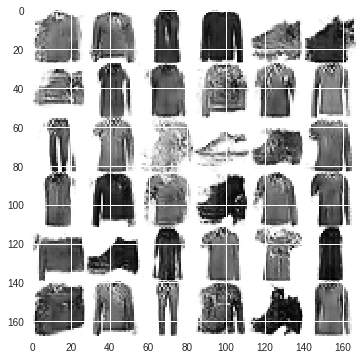

D Loss: 0.00780355 D Accuracy: 100.0 G Loss: 4.652774


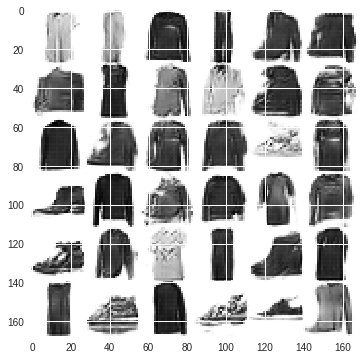

D Loss: 0.08327735 D Accuracy: 97.65625 G Loss: 3.9317927


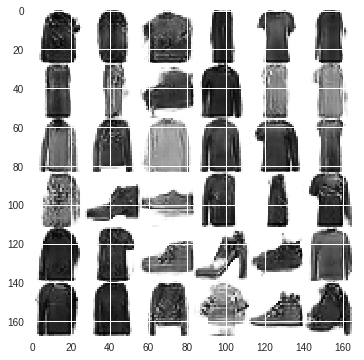

D Loss: 0.19643712 D Accuracy: 92.96875 G Loss: 6.9229183


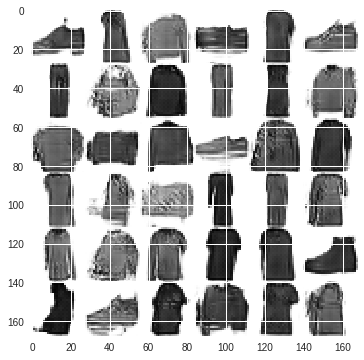

D Loss: 0.098228335 D Accuracy: 99.21875 G Loss: 5.102975


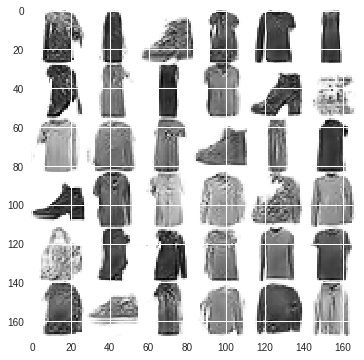

D Loss: 0.021020614 D Accuracy: 100.0 G Loss: 3.1308835


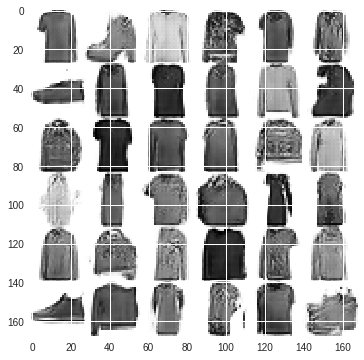

D Loss: 0.05285745 D Accuracy: 100.0 G Loss: 7.1856623


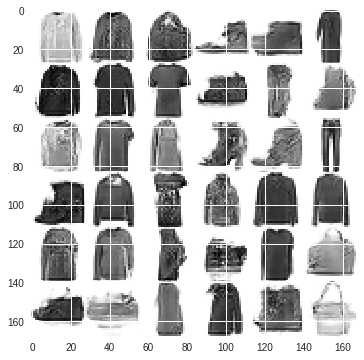

D Loss: 0.09916897 D Accuracy: 98.4375 G Loss: 3.8602657


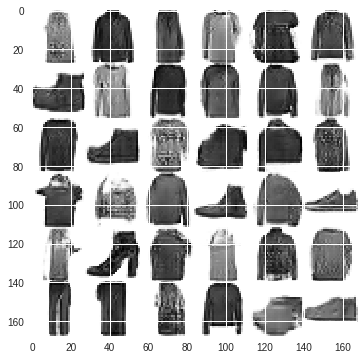

D Loss: 0.0075640236 D Accuracy: 100.0 G Loss: 2.2660265


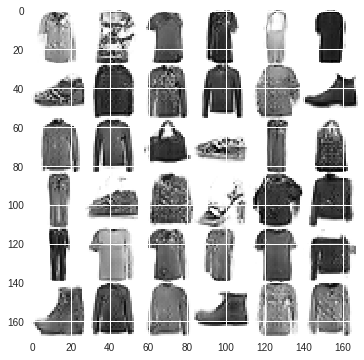

D Loss: 0.10322015 D Accuracy: 98.4375 G Loss: 5.496475


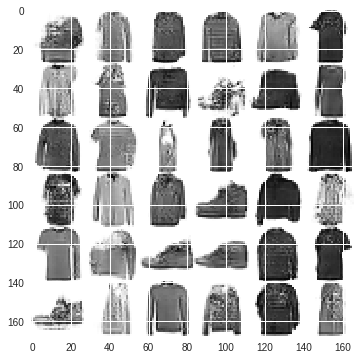

D Loss: 0.07710013 D Accuracy: 99.21875 G Loss: 6.088004


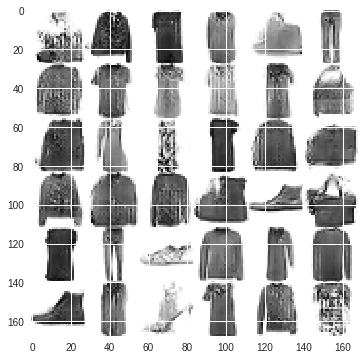

D Loss: 0.00040758587 D Accuracy: 100.0 G Loss: 2.7287045


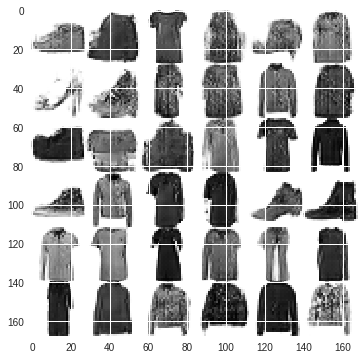

D Loss: 0.043832578 D Accuracy: 100.0 G Loss: 5.537345


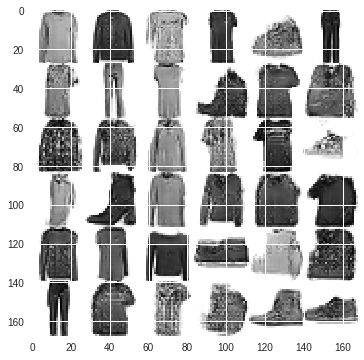

D Loss: 0.013537019 D Accuracy: 99.21875 G Loss: 3.3878143


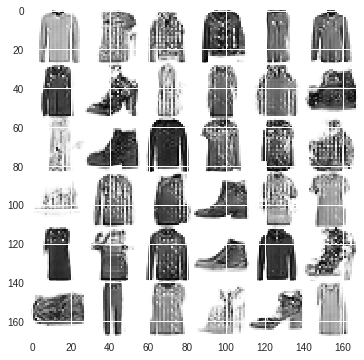

In [9]:
train(x_train, iterations, batch_size, display_iter)